# 1) Authentication and mounting data from Azure Blob Storage.

In [ ]:
from pyspark.sql import SparkSession
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
spark = pyspark.sql.SparkSession.builder \
        .appName("MyApp") \
        .master("local[*]") \
        .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8, ai.catboost:catboost-spark_3.5_2.12:1.2.5") \
        .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
        .getOrCreate()



Notes: For config, if it is not install or received 'TypeError: 'JavaPackage' object is not callable.' then do the following steps:
- Go to Compute
- Go to Libraries -> Install New -> Choose Maven -> Paste your package eg: 'com.microsoft.azure:synapseml_2.12:1.0.8' in Coordinates and install


In [ ]:
#dbutils.fs.unmount("/mnt/heartssss")


/mnt/heartssss has been unmounted.


True

SAS Token located => Go to your storageAccountName/Security + networking/Shared access signature


In [ ]:
container_name = "heartssss"
storageAccountName = "datasetz"
sas = "sv=2022-11-02&ss=bfqt&srt=sco&sp=rwdlacupiytfx&se=2024-10-30T10:13:20Z&st=2024-10-16T02:13:20Z&spr=https&sig=2TGIKLqTLIIgElZrCi133XtMFT1NTTkT66gpG%2BsTh%2BU%3D"

url = 'wasbs://' + container_name + '@' + storageAccountName + '.blob.core.windows.net/'
config = 'fs.azure.sas.' + container_name + '.' + storageAccountName + '.blob.core.windows.net'

dbutils.fs.mount(
    source = url,
    mount_point = "/mnt/heartssss",
    extra_configs = {config: sas}
)


True

In [ ]:
dbutils.fs.ls('/mnt/heartssss')

[FileInfo(path='dbfs:/mnt/heartssss/heart.csv', name='heart.csv', size=35921, modificationTime=1728982630000)]

# 2) Set the correct data type for each feature

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

schema = StructType([
    StructField("Age", IntegerType(), True),
    StructField("Sex", StringType(), True),
    StructField("ChestPainType", StringType(), True),
    StructField("RestingBP", IntegerType(), True),
    StructField("Cholesterol", IntegerType(), True),
    StructField("FastingBS", StringType(), True),
    StructField("RestingECG", StringType(), True),
    StructField("MaxHeartRate", IntegerType(), True),
    StructField("ExerciseAngina", StringType(), True),
    StructField("Oldpeak", DoubleType(), True),
    StructField("ST_Slope", StringType(), True),
    StructField("HeartDisease", IntegerType(), True)
 ])

# 3) Load Data from Azure Blob

In [ ]:
df = spark.read.csv("/mnt/heartssss/heart.csv", schema = schema, header = True)
df.show(5)

+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHeartRate|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|         172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|         156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|          98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|         108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|         122|             N|    0.0|      Up|           0|


In [ ]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: string (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHeartRate: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [ ]:
print(df.count(), len(df.columns))

918 12


# 4) Missing Value and Duplicate Value

In [ ]:
from pyspark.sql import functions as F

nulls = df.select([F.count(F.when(F.col(column).isNull(), column)).alias(column) for column in df.columns])
nulls.show()

+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHeartRate|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|           0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+



In [ ]:
duplicates = df.groupBy(df.columns).count().filter(F.col("count") > 1)
duplicates.show()

+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+-----+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHeartRate|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|count|
+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+-----+
+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+-----+



In [ ]:
df_pandas = df.toPandas()

# 5) Is the target balance?

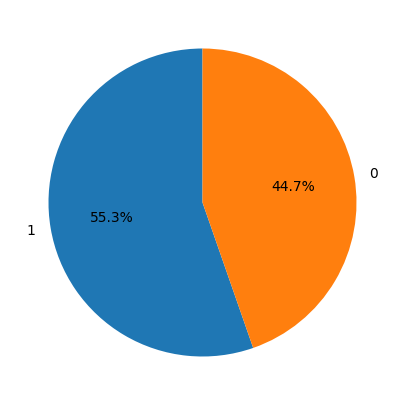

In [ ]:
v= df_pandas['HeartDisease'].value_counts()
plt.figure(figsize = (7,5))

plt.pie(v, labels= v.index, autopct = '%1.1f%%', startangle = 90)
plt.show()

# 6) Univariate Analysis

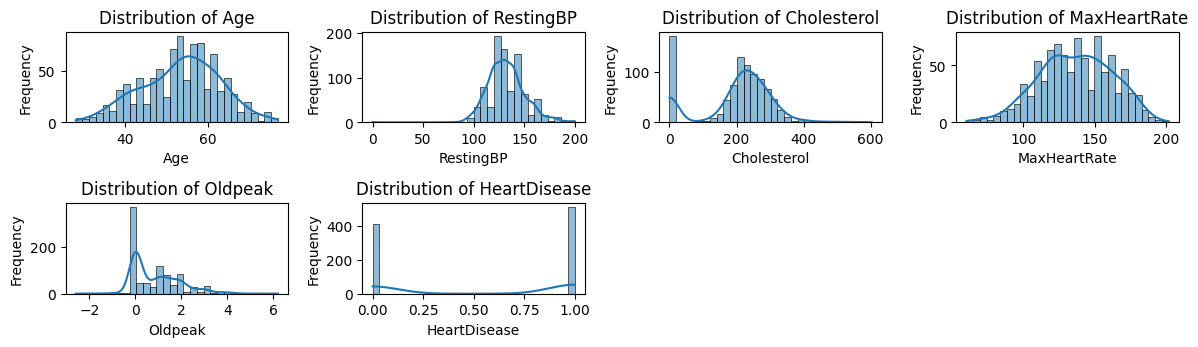

In [ ]:

plt.figure(figsize=(12, 10))

for i, column in enumerate(df_pandas.select_dtypes(include=['int32','float64', 'int64']).columns, 1):
    plt.subplot(6, 4, i)  
    sns.histplot(df_pandas[column], bins=30, kde=True) 
    plt.title(f'Distribution of {column}')  
    plt.xlabel(column) 
    plt.ylabel('Frequency') 

plt.tight_layout()
plt.show()

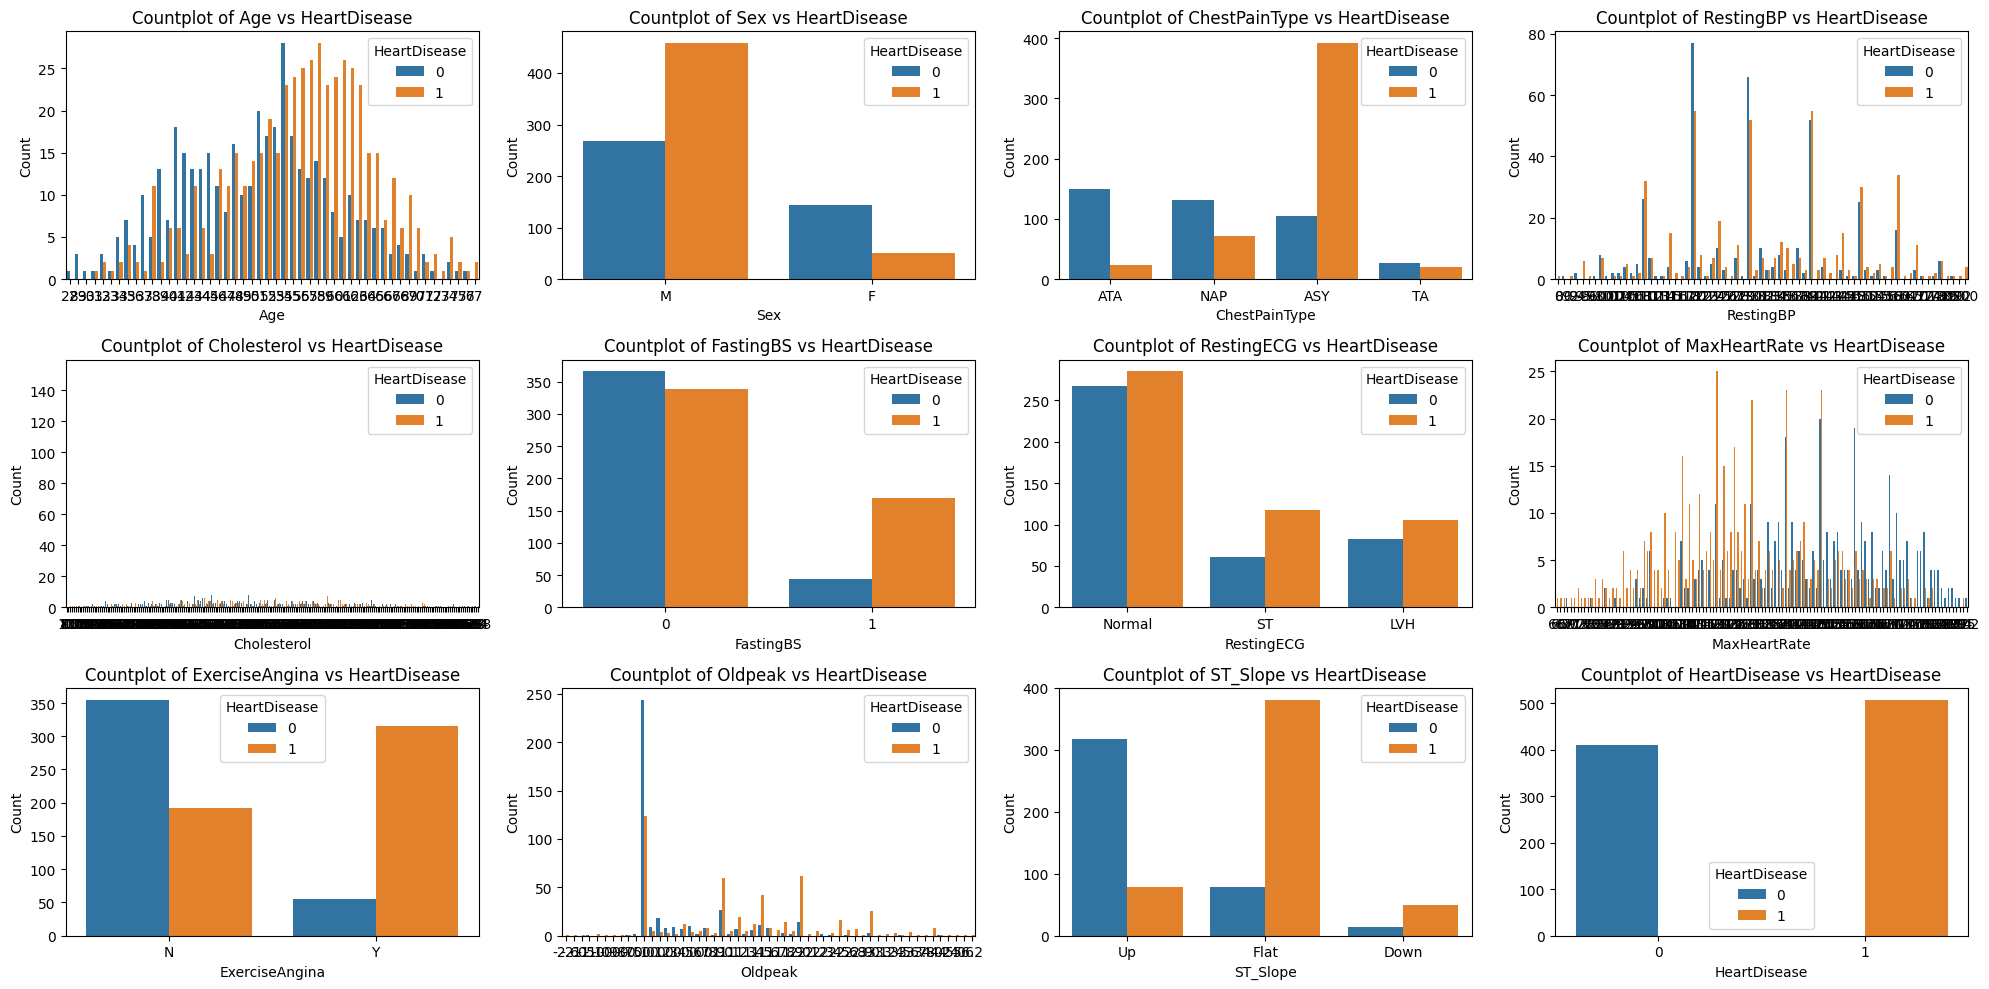

In [ ]:
fig, axes = plt.subplots(3,4, figsize = (20,10))

for i, (feature, ax) in enumerate(zip(df_pandas.columns, axes.flatten())):
    sns.countplot(x = feature, hue= 'HeartDisease', data = df_pandas, ax = ax)
    ax.set_title(f'Countplot of {feature} vs HeartDisease')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# 7) SKewness

In [ ]:
# numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',]
# cat_cols = ['Sex', 'ChestPainType', 'FastingBS','RestingECG',
#        'ExerciseAngina', 'ST_Slope']

# 7.1) Before Adjusting Skewness

In [ ]:
from pyspark.sql.types import IntegerType,DoubleType,FloatType

numerical = [col for col, dtype in df.dtypes if dtype in ('int', 'float', 'double')]
numerical

['Age', 'RestingBP', 'Cholesterol', 'MaxHeartRate', 'Oldpeak', 'HeartDisease']

In [ ]:
categorical = [col for col, dtype in df.dtypes if dtype in ('string')]
categorical

['Sex',
 'ChestPainType',
 'FastingBS',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope']

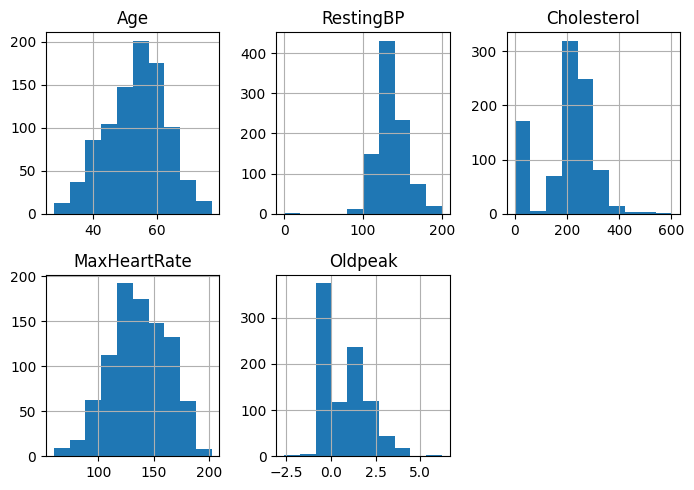

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (7, 5))
axes = axes.flatten()
for i, col in enumerate(df_pandas[numerical].columns):
    df_pandas[col].hist(ax=axes[i])
    axes[i].set_title(col)
    
fig.delaxes(axes[-1]) 
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import skewness

skewness_val = {col: df.agg(skewness(col)).collect()[0][0] for col in numerical}
skewness_df = pd.DataFrame(list(skewness_val.items()), columns=['Feature', 'Skewness']).sort_values(by='Skewness', ascending=False)
skewness_df

,Feature,Skewness
4,Oldpeak,1.021200
1,RestingBP,0.179545
3,MaxHeartRate,-0.144123
0,Age,-0.195613
5,HeartDisease,-0.214735
2,Cholesterol,-0.609089


In [ ]:
from scipy import stats
from scipy.stats import boxcox

df_pandas = df.toPandas()

constant = abs(df_pandas['Oldpeak'].min()) + 1
df_pandas['Oldpeak'] += constant

if len(df_pandas['Oldpeak'].unique()) > 1:  
    transformed_data, lambda_val = stats.boxcox(df_pandas['Oldpeak'])
    df_pandas['Oldpeak_box_cox'] = transformed_data 
else:
    print("Oldpeak values are constant after shifting. Skipping Box-Cox transformation.")


df1 = spark.createDataFrame(df_pandas)
df1.show(5)

+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+------------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHeartRate|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|   Oldpeak_box_cox|
+---+---+-------------+---------+-----------+---------+----------+------------+--------------+-------+--------+------------+------------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|         172|             N|    3.6|      Up|           0|1.1670435801924577|
| 49|  F|          NAP|      160|        180|        0|    Normal|         156|             N|    4.6|    Flat|           1|1.3662804387727345|
| 37|  M|          ATA|      130|        283|        0|        ST|          98|             N|    3.6|      Up|           0|1.1670435801924577|
| 48|  F|          ASY|      138|        214|        0|    Normal|         108|             Y|    5.1|    Flat|           1|1.4480154478

In [ ]:
from pyspark.sql.functions import col

df1 = df1.withColumn("Cholesterol_transformed", col("Cholesterol") ** 1.35)

In [ ]:
df1 = df1.drop('Oldpeak',  'Cholesterol')

In [ ]:
df_pandas = df1.toPandas()
numerical_cols = [field.name for field in df1.schema.fields if field.dataType.typeName() in ['double', 'float', 'integer'] and field.name != 'HeartDisease']
numerical_cols

['Age',
 'RestingBP',
 'MaxHeartRate',
 'Oldpeak_box_cox',
 'Cholesterol_transformed']

# 7.2) After Adjusting Skewness

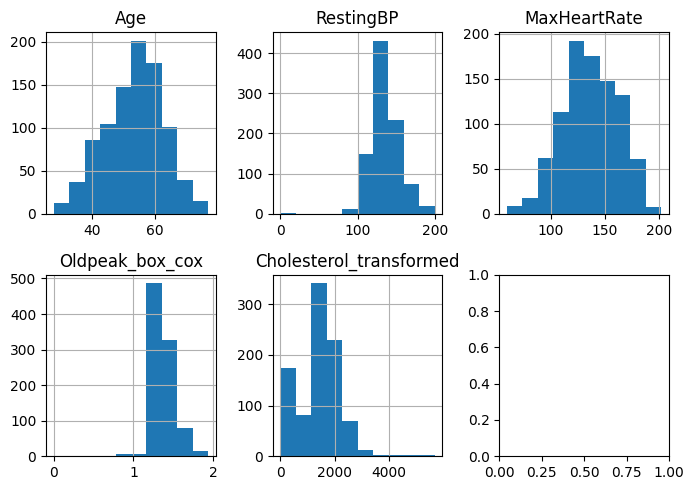

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (7, 5))
axes = axes.flatten()
for i, col in enumerate(df_pandas[numerical_cols].columns):
    df_pandas[col].hist(ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

In [ ]:
skewness_val = {col: df1.agg(skewness(col)).collect()[0][0] for col in numerical_cols}
skewness_df = pd.DataFrame(list(skewness_val.items()), columns=['Feature', 'Skewness']).sort_values(by='Skewness', ascending=False)
skewness_df

,Feature,Skewness
1,RestingBP,0.179545
4,Cholesterol_transformed,0.094522
3,Oldpeak_box_cox,-0.027964
2,MaxHeartRate,-0.144123
0,Age,-0.195613


# 8) Bivariate/ Multivarite Analysis

# 8.1) Sex vs HeartDisease

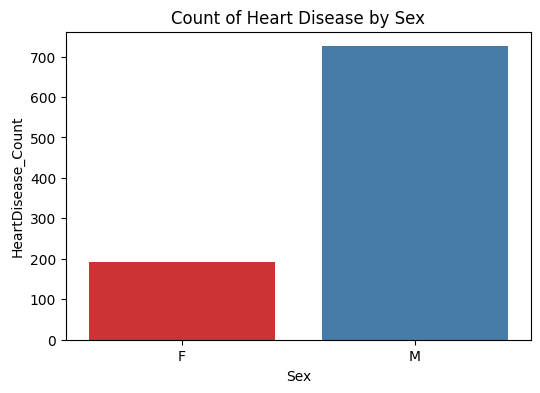

In [ ]:
groupby1 = df1.groupBy('Sex').agg({'HeartDisease': 'count'}).toPandas()
groupby1.columns = ['Sex', 'HeartDisease_Count']

plt.figure(figsize = (6, 4))
sns.barplot(x = 'Sex', y = 'HeartDisease_Count', data = groupby1, palette= 'Set1')
plt.title('Count of Heart Disease by Sex')
plt.xlabel('Sex')
plt.ylabel('HeartDisease_Count')
plt.show()

Men is likely to get Heart Disease compared to women

# 8.2) Age Vs Chest Pain Type

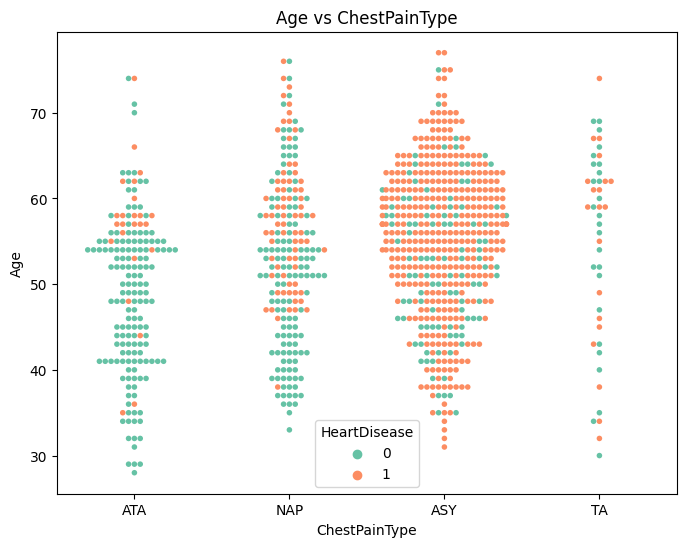

In [ ]:
plt.figure(figsize=(8, 6))
sns.swarmplot(y='Age',x='ChestPainType',data=df_pandas, hue = 'HeartDisease', size = 4, palette="Set2")
plt.title('Age vs ChestPainType')
plt.xlabel('ChestPainType')
plt.ylabel('Age')
plt.show() 

It is likely that Chest Pain ASY has a much higher chances of getting Heart Disease.

# 8.3) Age Vs Cholestero

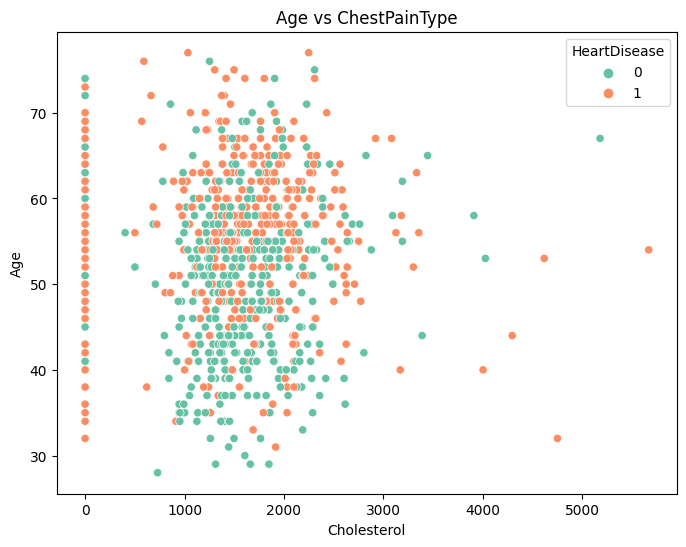

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(y='Age',x='Cholesterol_transformed', hue = 'HeartDisease', data=df_pandas, palette="Set2")
plt.title('Age vs ChestPainType')
plt.xlabel('Cholesterol')
plt.ylabel('Age')
plt.show() 

Individuals with cholesterol levels between 1000 and 3000 mg/dL are at a significantly higher risk of developing heart disease. Additionally, the age group of 30 to 60 years has the highest incidence of heart disease, suggesting that both elevated cholesterol and this age range are critical factors in assessing heart health.

# 8.4) Age Vs Sex

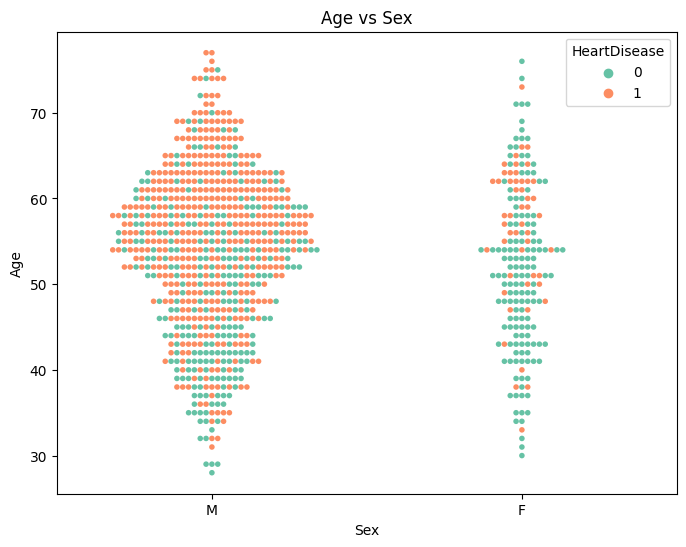

In [ ]:
plt.figure(figsize=(8, 6))
sns.swarmplot(y='Age',x='Sex',data=df_pandas, hue = 'HeartDisease', size = 4, palette="Set2")
plt.title('Age vs Sex')
plt.xlabel('Sex')
plt.ylabel('Age')
plt.show() 
plt.show() 

Older Men is likely to get Heart Disease compare the women

# 9) Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

df1_pandas = df1.toPandas()
selector = SelectKBest(f_classif, k='all')
X_anova  = selector.fit_transform(df1_pandas[numerical_cols], df1_pandas['HeartDisease'])

anova_scores = selector.scores_
p_values = selector.pvalues_

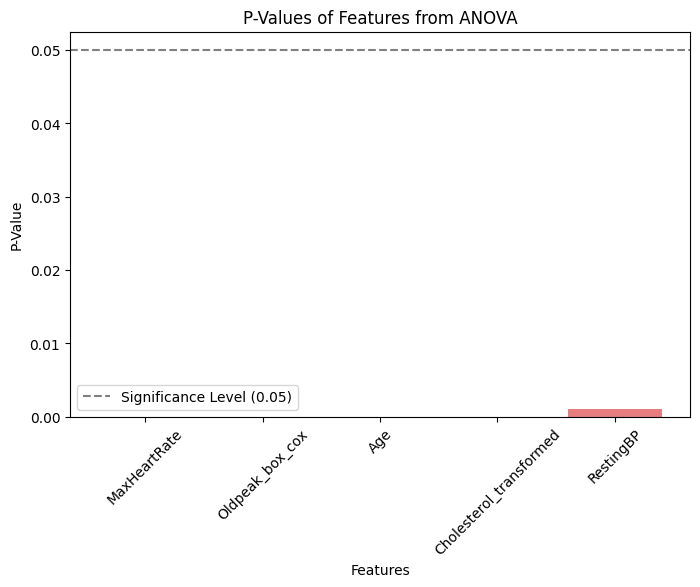

In [ ]:
results_df = pd.DataFrame({
    'Feature': numerical_cols,
    'P-Value': p_values,
    'Scores' :anova_scores
})


results_df.sort_values(by='P-Value', ascending=True, inplace=True)

plt.figure(figsize=(8, 5))
plt.bar(results_df['Feature'], results_df['P-Value'], color='tab:red', alpha=0.6)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.title('P-Values of Features from ANOVA')
plt.axhline(y=0.05, color='gray', linestyle='--', label='Significance Level (0.05)')
plt.legend()
plt.show()

Since all features have p-values below 0.05, we can conclude that they are statistically significant predictors of the outcome variable. Therefore, we will retain all features for machine learning.

In [ ]:
df_pandas = df1.toPandas()
X = pd.get_dummies(df_pandas[categorical])
y = df_pandas['HeartDisease']

chi_scores = chi2(X,y)
chi_scores[1]

array([1.96242309e-16, 2.20181680e-05, 2.54558008e-26, 5.30421243e-28,
       1.23706849e-08, 1.05676165e-01, 9.22453327e-05, 1.32152556e-12,
       7.73122604e-01, 7.97690266e-02, 5.28642125e-03, 1.72275628e-21,
       6.54928900e-31, 3.40025979e-04, 1.93323301e-32, 6.10685791e-46])

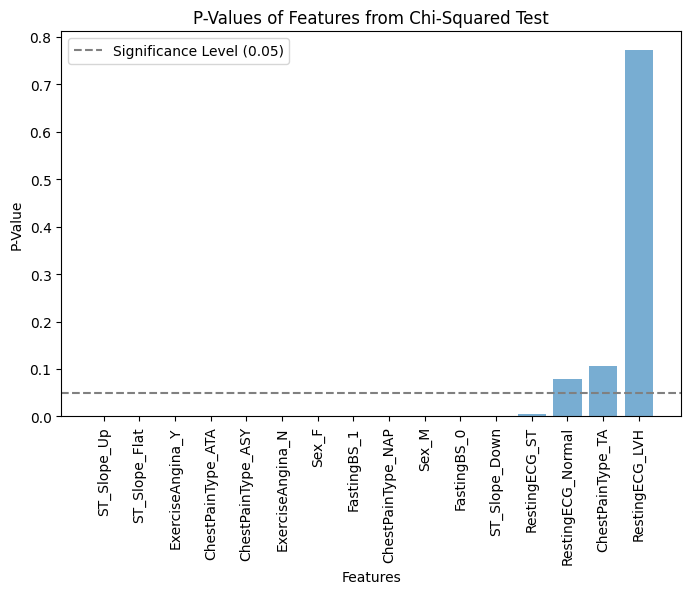

In [ ]:
chi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi-Squared Score': chi_scores[0],
    'P-Value': chi_scores[1]
})

chi_scores_df.sort_values(by='P-Value', ascending=True, inplace=True)

plt.figure(figsize=(8, 5))
plt.bar(chi_scores_df['Feature'], chi_scores_df['P-Value'], color='tab:blue', alpha=0.6)
plt.xlabel('Features')
plt.ylabel('P-Value')
plt.title('P-Values of Features from Chi-Squared Test')
plt.axhline(y=0.05, color='gray', linestyle='--', label='Significance Level (0.05)')
plt.xticks(rotation=90)  
plt.legend()
plt.show()

We will remove the features RestingECG_LVH and ChestPainType_TA from the analysis because their p-values are greater than 0.05, indicating that they are not statistically significant predictors of the outcome variable.

In [ ]:
df2 = df1.filter((df1['RestingECG'] != 'LVH') & (df1['ChestPainType'] != 'TA'))
df2.show(5)

+---+---+-------------+---------+---------+----------+------------+--------------+--------+------------+------------------+-----------------------+
|Age|Sex|ChestPainType|RestingBP|FastingBS|RestingECG|MaxHeartRate|ExerciseAngina|ST_Slope|HeartDisease|   Oldpeak_box_cox|Cholesterol_transformed|
+---+---+-------------+---------+---------+----------+------------+--------------+--------+------------+------------------+-----------------------+
| 40|  M|          ATA|      140|        0|    Normal|         172|             N|      Up|           0|1.1670435801924577|       2099.96515129372|
| 49|  F|          NAP|      160|        0|    Normal|         156|             N|    Flat|           1|1.3662804387727345|     1108.1993265121953|
| 37|  M|          ATA|      130|        0|        ST|          98|             N|      Up|           0|1.1670435801924577|     2041.3228076515848|
| 48|  F|          ASY|      138|        0|    Normal|         108|             Y|    Flat|           1|1.448015

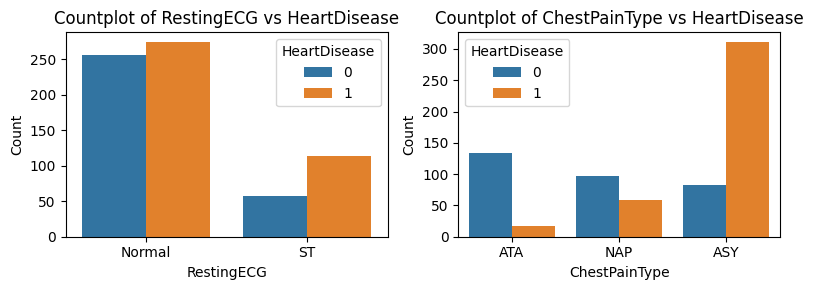

In [ ]:
df2_pandas = df2.toPandas()
fig, axes = plt.subplots(1,2, figsize = (8,3))

for i, (feature, ax) in enumerate(zip(['RestingECG', 'ChestPainType'], axes.flatten())):
    sns.countplot(x = feature, hue= 'HeartDisease', data = df2_pandas, ax = ax)
    ax.set_title(f'Countplot of {feature} vs HeartDisease')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

We can see that we have successfully removed the two classes.

# 10) Outliers

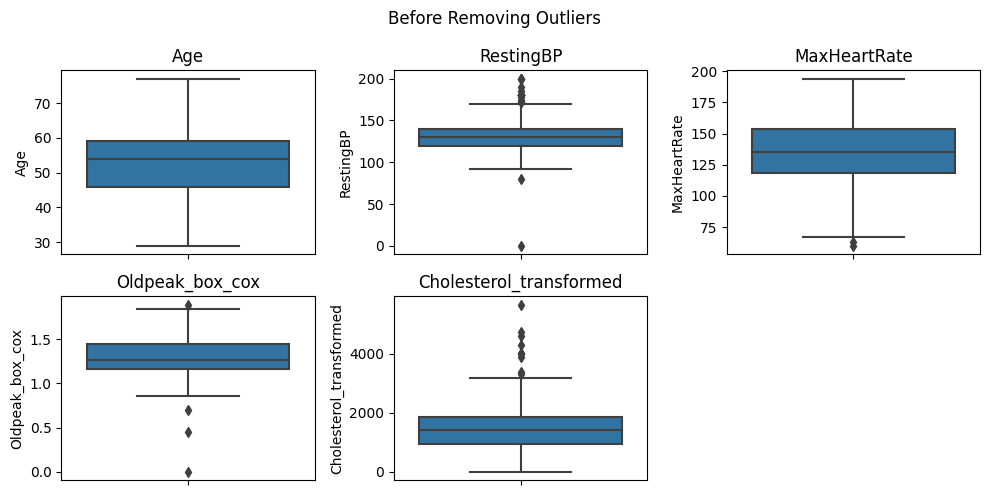

In [ ]:

fig, axes = plt.subplots(2, 3, figsize = (10,5))

axes = axes.flatten()

for i, (feature, ax) in enumerate(zip(numerical_cols, axes)):
    sns.boxplot(y = feature , data = df2_pandas, ax = ax)
    ax.set_title(f'{feature}')
    
for j in range(i+1, len(axes)):  
    axes[j].set_visible(False) 
    
plt.suptitle('Before Removing Outliers') 
plt.tight_layout()
plt.show()

There is one outlier in the RestingBP column. It is unrealistic for RestingBP to be 0.

In [ ]:
def lower_upper_bound(df, feature):
    quantiles = df.approxQuantile(feature, [0.25, 0.75], 0.01) 
    q1, q3 = quantiles[0], quantiles[1]

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

for feature in numerical_cols:
    lower_bound, upper_bound = lower_upper_bound(df2, feature)
    df2 = df2.filter((F.col(feature) >= lower_bound) & (F.col(feature) <= upper_bound))
    print(f'{feature}: Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

Age: Lower Bound: 26.5, Upper Bound: 78.5
RestingBP: Lower Bound: 90.0, Upper Bound: 170.0
MaxHeartRate: Lower Bound: 61.5, Upper Bound: 209.5
Oldpeak_box_cox: Lower Bound: 0.7455857787004178, Upper Bound: 1.8694732493458575
Cholesterol_transformed: Lower Bound: -367.6885368762107, Upper Bound: 3133.569643470315


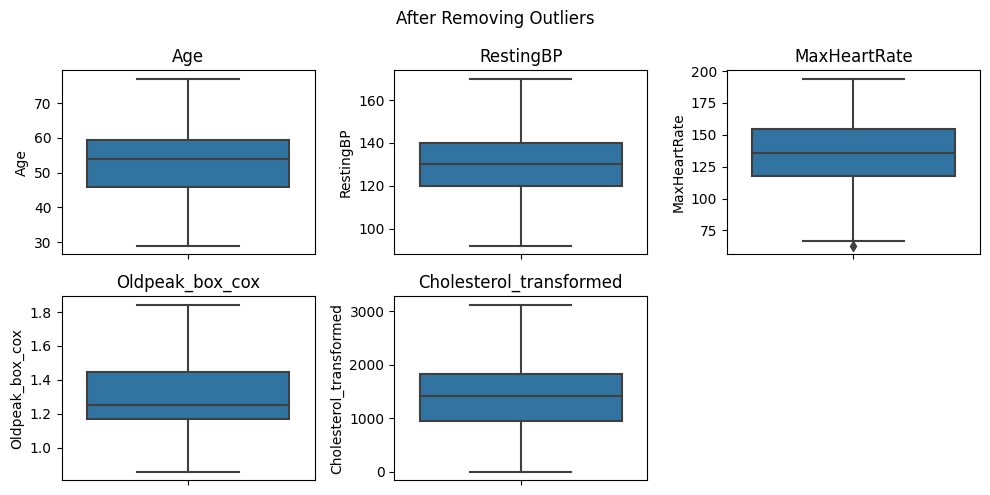

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (10,5))

axes = axes.flatten()

for i, (feature, ax) in enumerate(zip(numerical_cols, axes)):
    sns.boxplot(y = feature , data = df2.toPandas(), ax = ax)
    ax.set_title(f'{feature}')
    
for j in range(i+1, len(axes)):  
    axes[j].set_visible(False) 
    
plt.suptitle('After Removing Outliers') 
plt.tight_layout()
plt.show()

# 11) Machine Learning

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

from xgboost.spark import SparkXGBClassifier
from synapse.ml.lightgbm import LightGBMClassifier
import catboost_spark

# Applying stratify in splitting data

In [ ]:

class_0 = df2.filter(df2['HeartDisease'] == 0)
class_1 = df2.filter(df2['HeartDisease'] == 1)

train_class_0, val_class_0, test_class_0 = class_0.randomSplit([0.7, 0.13, 0.17], seed=40)
train_class_1, val_class_1, test_class_1 = class_1.randomSplit([0.7, 0.13, 0.17], seed=40)

train_df = train_class_0.union(train_class_1)
val_df = val_class_0.union(val_class_1)
test_df = test_class_0.union(test_class_1)

train_df = train_df.withColumn("random_state", F.rand(seed=40)).orderBy("random_state").drop("random_state")
val_df = val_df.withColumn("random_state", F.rand(seed=40)).orderBy("random_state").drop("random_state")
test_df = test_df.withColumn("random_state", F.rand(seed=40)).orderBy("random_state").drop("random_state")

print("Training set count:", train_df.count())
print("Validation set count:", val_df.count())
print("Test set count:", test_df.count())



Training set count: 448
Validation set count: 103
Test set count: 112


In [ ]:
print(numerical_cols, categorical)

['Age', 'RestingBP', 'MaxHeartRate', 'Oldpeak_box_cox', 'Cholesterol_transformed'] ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


# Create Pipeline for Training and Testing dataset

In [ ]:
indexers = [StringIndexer(inputCol=cat, outputCol=cat + '_index') for cat in categorical]
encoders = [OneHotEncoder(inputCol=cat + '_index', outputCol= cat + '_onehot') for cat in categorical]


numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='num_features')
scalers = StandardScaler(inputCol='num_features', outputCol='scaled_features')

final_assembler = VectorAssembler(inputCols=['scaled_features'] + [cat + '_onehot' for cat in categorical], outputCol='final_features')

pipeline = Pipeline(stages=indexers + encoders + [numerical_assembler, scalers, final_assembler])

pipeline_model = pipeline.fit(train_df)  
train_df_transformed = pipeline_model.transform(train_df)
val_df_transformed = pipeline_model.transform(val_df)
test_df_transformed = pipeline_model.transform(test_df)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

train_df_transformed.select('final_features').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                |
+------------------------------------------------------------------------------------------------------------------------------+
|(13,[0,1,2,3,6,9,10],[6.7819010783998435,5.904140579717981,5.6892596464373755,7.989185153631917,1.0,1.0,1.0])                 |
|[6.4639994653498505,9.943815713209233,5.6892596464373755,7.890210683984964,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0]               |
|[4.344655378349899,7.457861784906924,5.414605732471434,7.890210683984964,2.0559987993565843,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0]  |
|[5.19239301314988,7.457861784906924,5.179188091929197,7.890210683984964,2.7882633880401513,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0]   |
|[5.298360217499877,10.565304195284808,4.5514077171499006,6.739626407432067,1.7350423342448764,1.

In [ ]:
lr_model = LogisticRegression(labelCol="HeartDisease", featuresCol="final_features")
gb_model = GBTClassifier(labelCol="HeartDisease", featuresCol="final_features")
dt_model = DecisionTreeClassifier(labelCol="HeartDisease", featuresCol="final_features")
rf_model = RandomForestClassifier(labelCol="HeartDisease", featuresCol="final_features")

#cat_model = catboost_spark.CatBoostClassifier(featuresCol='final_features', labelCol='HeartDisease')
xgb_model = SparkXGBClassifier(features_col='final_features',label_col='HeartDisease')
lgbm_model = LightGBMClassifier(objective = "binary", labelCol = 'HeartDisease', featuresCol = 'final_features')

#models = ('LG',lr_model), ('GB', gb_model), ('DT', dt_model), ('RF', rf_model),  ('CAT', cat_model), ('XGB', xgb_model), ('LGB', lgbm_model)
models = ('LG',lr_model), ('GB', gb_model), ('DT', dt_model), ('RF', rf_model),  ('XGB', xgb_model), ('LGB', lgbm_model) 

In [ ]:
####################################################### For Cross Validation #################################################################

# def evaluator(model):
#     f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
    
#     paramGrid = ParamGridBuilder().build()
#     crossval = CrossValidator(estimator=model, 
#                               estimatorParamMaps=paramGrid, 
#                               evaluator=f1_evaluator, 
#                               numFolds=5, 
#                               collectSubModels=True, 
#                               seed=40,
#                               parallelism=4)

#     cv_model = crossval.fit(train_df_transformed)
   
#     average_f1_score = cv_model.avgMetrics

#     return average_f1_score

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-3702832231649504>, line 13
      8 cat = catboost_spark.CatBoostClassifier(featuresCol='final_features', 
      9                                         labelCol='HeartDisease',
     10                                         iterations=100)
     12 f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
---> 13 model = cat.fit(train_df_transformed)

File /local_disk0/spark-8852ce6e-6297-4f9e-81b1-efed53edbad5/userFiles-4b84b775-84ad-43cb-8244-61b054b53236/ai_catboost_catboost_spark_3_5_2_12_1_2_6.jar/catboost_spark/core.py:5346, in CatBoostClassifier.fit(self, dataset, params, evalDatasets)
   5344     if evalDatasets is not None:
   5345         raise RuntimeError("if dataset has type DataFrame no evalDatasets are supported")
-> 5346     return JavaEstimator

In [ ]:
def evaluator(classifier):
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
    
    model = classifier.fit(train_df_transformed)

    val_predictions = model.transform(val_df_transformed)
    val_f1_score = f1_evaluator.evaluate(val_predictions)
    return val_f1_score

In [ ]:
results = []
for model_name, model in models:
    f1_score = evaluator(model)
    results.append({
            'Model': model_name,
            'F1 Score': f1_score
        })

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

2024-10-21 06:09:20,294 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}

2024-10-21 06:09:27,822 INFO XGBoost-PySpark: _fit Finished xgboost training!
INFO:XGBoost-PySpark:Finished xgboost training!



Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
result_df = pd.DataFrame(results)
result_df.sort_values(by='F1 Score', ascending=False)

,Model,F1 Score
3,RF,0.941748
5,LGB,0.922403
4,XGB,0.902968
0,LG,0.902913
1,GB,0.873929
2,DT,0.873929


# Model Fine Tunning

In [ ]:
import mlflow
import mlflow.spark
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials

## Random Forest

In [ ]:
def objective(params):
     with mlflow.start_run():
        
        mlflow.log_params(params)
        rf = RandomForestClassifier(
            numTrees=int(params['numTrees']),
            maxDepth=int(params['maxDepth']),
            minInstancesPerNode=int(params['minInstancesPerNode']),
            maxBins=int(params['maxBins']),
            featureSubsetStrategy=params['featureSubsetStrategy'],
            impurity=params['impurity'],
            labelCol='HeartDisease',
            featuresCol='final_features'
        )
        
        
        f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
        model = rf.fit(train_df_transformed)

        val_predictions = model.transform(val_df_transformed)
        val_f1_score = f1_evaluator.evaluate(val_predictions)

        return {'loss': -val_f1_score, 'status': STATUS_OK}

space = {
    'numTrees': hp.quniform('numTrees', 50, 500, 1),               
    'maxDepth': hp.quniform('maxDepth', 1, 15, 1),                    
    'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1), 
    'maxBins': hp.quniform('maxBins', 2, 32, 1),                    
    'featureSubsetStrategy': hp.choice('featureSubsetStrategy', ['auto', 'all', 'sqrt', 'log2']), 
    'impurity': hp.choice('impurity', ['gini', 'entropy'])           
}

trials = Trials()
spark_trials = SparkTrials(parallelism=4)

best_hyperparams_rf = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,    
)

print("Best hyperparameters found:")
print(best_hyperparams_rf)

100%|██████████| 30/30 [08:18<00:00, 16.60s/trial, best loss: -0.9514838584083474]
Best hyperparameters found:
{'featureSubsetStrategy': 2, 'impurity': 0, 'maxBins': 11.0, 'maxDepth': 15.0, 'minInstancesPerNode': 3.0, 'numTrees': 175.0}


In [ ]:
best_hyperparams_rf = {'featureSubsetStrategy': 'log2', 
                        'impurity': 'gini',
                        'maxBins': 11.0, 
                        'maxDepth': 15.0, 
                        'minInstancesPerNode': 3.0, 
                        'numTrees': 175.0}

best_rf = RandomForestClassifier(
            numTrees=int(best_hyperparams_rf['numTrees']),
            maxDepth=int(best_hyperparams_rf['maxDepth']),
            minInstancesPerNode=int(best_hyperparams_rf['minInstancesPerNode']),
            maxBins=int(best_hyperparams_rf['maxBins']),
            featureSubsetStrategy=best_hyperparams_rf['featureSubsetStrategy'],
            impurity=best_hyperparams_rf['impurity'],
            labelCol='HeartDisease',
            featuresCol='final_features'
        )

model_rf = best_rf.fit(train_df_transformed)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")

val_predictions = model_rf.transform(val_df_transformed)

f1_score = f1_evaluator.evaluate(val_predictions)
precision = precision_evaluator.evaluate(val_predictions)
recall = recall_evaluator.evaluate(val_predictions)

rf_df = pd.DataFrame({
    'Model' : ['Random Forest'],
    'F1 Score': [f1_score],   
    'Precision': [precision],
    'Recall': [recall]
}, index=[0])  

rf_df

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,F1 Score,Precision,Recall
0,Random Forest,0.941748,0.941748,0.941748


## LightGBMClassifier

In [ ]:
def objective(params):
     with mlflow.start_run():
        
        mlflow.log_params(params)
        lgb = LightGBMClassifier(
            objective="binary",
            labelCol='HeartDisease',
            featuresCol='final_features'
        )
        
        lgb = lgb.setLearningRate(params['learning_rate']) \
                 .setNumLeaves(int(params['num_leaves'])) \
                 .setMaxDepth(int(params['max_depth'])) \
                 .setMinDataInLeaf(int(params['min_data_in_leaf'])) \
                 .setMinGainToSplit(params['min_gain_to_split']) \
                 .setBoostingType(params['boosting_type']) \
                 .setNumIterations(int(params['n_estimators'])) \
                 .setLambdaL1(params['lambda_l1']) \
                 .setLambdaL2(params['lambda_l2'])

        f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")


        model = lgb.fit(train_df_transformed)

        val_predictions = model.transform(val_df_transformed)
        val_f1_score = f1_evaluator.evaluate(val_predictions)

        return {'loss': -val_f1_score, 'status': STATUS_OK}

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.05),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 10, 100, 1),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0.0, 1.0),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
    'n_estimators': hp.quniform('n_estimators', 500, 1000, 1),
    'lambda_l1': hp.uniform('lambda_l1', 0, 1), 
    'lambda_l2': hp.uniform('lambda_l2', 0, 1),  
}

trials = Trials()
#spark_trials = SparkTrials(parallelism=4)

best_hyperparams_lgb = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,    
)

print("Best hyperparameters found:")
print(best_hyperparams_lgb)

100%|██████████| 50/50 [08:14<00:00,  9.89s/trial, best loss: -0.9514838584083474]
Best hyperparameters found:
{'boosting_type': 0, 'lambda_l1': 0.27620575559776694, 'lambda_l2': 0.9772563419230704, 'learning_rate': 0.017050808225259315, 'max_depth': 12.0, 'min_data_in_leaf': 25.0, 'min_gain_to_split': 0.9837550490192833, 'n_estimators': 890.0, 'num_leaves': 44.0}


In [ ]:
best_lgb = LightGBMClassifier(
            objective="binary",
            labelCol='HeartDisease',
            featuresCol='final_features', 
        )

best_hyperparams_lgb ={'boosting_type': 'gbdt', 
                       'lambda_l1': 0.27620575559776694, 
                       'lambda_l2': 0.9772563419230704, 
                       'learning_rate': 0.017050808225259315, 
                       'max_depth': 12.0, 
                       'min_data_in_leaf': 25.0, 
                       'min_gain_to_split': 0.9837550490192833, 
                       'n_estimators': 890.0, 
                       'num_leaves': 44.0}

best_lgb = best_lgb.setLearningRate(best_hyperparams_lgb['learning_rate']) \
                   .setNumLeaves(int(best_hyperparams_lgb['num_leaves'])) \
                   .setMaxDepth(int(best_hyperparams_lgb['max_depth'])) \
                   .setMinDataInLeaf(int(best_hyperparams_lgb['min_data_in_leaf'])) \
                   .setMinGainToSplit(best_hyperparams_lgb['min_gain_to_split']) \
                   .setBoostingType(best_hyperparams_lgb['boosting_type']) \
                   .setNumIterations(int(best_hyperparams_lgb['n_estimators'])) \
                   .setLambdaL1(best_hyperparams_lgb['lambda_l1']) \
                   .setLambdaL2(best_hyperparams_lgb['lambda_l2'])

model_lgb = best_lgb.fit(train_df_transformed)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")

val_predictions = model_lgb.transform(val_df_transformed)

f1_score = f1_evaluator.evaluate(val_predictions)
precision = precision_evaluator.evaluate(val_predictions)
recall = recall_evaluator.evaluate(val_predictions)

lgb_df = pd.DataFrame({
    'Model' : ['LightGBM'],
    'F1 Score': [f1_score],   
    'Precision': [precision],
    'Recall': [recall]
}, index=[0])  

lgb_df

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,F1 Score,Precision,Recall
0,LightGBM,0.951484,0.951691,0.951456


## LogisticRegression

In [ ]:
def objective(params):
     with mlflow.start_run():
        
        mlflow.log_params(params)
        lg = LogisticRegression(
            regParam=params['regParam'],
            elasticNetParam=params['elasticNetParam'],
            maxIter=int(params['maxIter']),
            tol=params['tol'],
            fitIntercept=params['fitIntercept'],
            family=params['family'],
            labelCol='HeartDisease',
            featuresCol='final_features'
        )
        
        f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
        model = lg.fit(train_df_transformed)

        val_predictions = model.transform(val_df_transformed)
        val_f1_score = f1_evaluator.evaluate(val_predictions)

        return {'loss': -val_f1_score, 'status': STATUS_OK}

space = {
    'regParam': hp.uniform('regParam', 0.0, 0.1),          
    'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0), 
    'maxIter': hp.quniform('maxIter', 50, 200, 1),         
    'tol': hp.uniform('tol', 1e-6, 1e-1),                   
    'fitIntercept': hp.choice('fitIntercept', [True, False]),
    'family': hp.choice('family', ['auto', 'binomial'])       
}

trials = Trials()
spark_trials = SparkTrials(parallelism=4)

best_hyperparams_lg = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,    
)

print("Best hyperparameters found:")
print(best_hyperparams_lg)

100%|██████████| 30/30 [03:28<00:00,  6.95s/trial, best loss: -0.9320774017716863]
Best hyperparameters found:
{'elasticNetParam': 0.6639257753846222, 'family': 1, 'fitIntercept': 1, 'maxIter': 180.0, 'regParam': 0.015098449758510213, 'tol': 0.05972163607333068}


In [ ]:
best_hyperparams_lg = {'elasticNetParam': 0.6639257753846222, 'family': 'binomial', 'fitIntercept': False, 'maxIter': 180.0, 'regParam': 0.015098449758510213, 'tol': 0.05972163607333068}

best_lg = LogisticRegression(
            regParam=best_hyperparams_lg['regParam'],
            elasticNetParam=best_hyperparams_lg['elasticNetParam'],
            maxIter=int(best_hyperparams_lg['maxIter']),
            tol=best_hyperparams_lg['tol'],
            fitIntercept=best_hyperparams_lg['fitIntercept'],
            family=best_hyperparams_lg['family'],
            labelCol='HeartDisease',
            featuresCol='final_features'
        )


model_lg = best_lg.fit(train_df_transformed)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")

val_predictions = model_lg.transform(val_df_transformed)

f1_score = f1_evaluator.evaluate(val_predictions)
precision = precision_evaluator.evaluate(val_predictions)
recall = recall_evaluator.evaluate(val_predictions)

lg_df = pd.DataFrame({
    'Model' : ['Logistic Regression'],
    'F1 Score': [f1_score],   
    'Precision': [precision],
    'Recall': [recall]
}, index=[0])  

lg_df

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,F1 Score,Precision,Recall
0,Logistic Regression,0.932077,0.932292,0.932039


## SparkXGBClassifier

In [ ]:
def objective(params):
     with mlflow.start_run():
        
        mlflow.log_params(params)
        xgb = SparkXGBClassifier(
            label_col='HeartDisease',
            features_col='final_features',
            learning_rate=params['learning_rate'],
            max_depth=int(params['max_depth']),
            n_estimators=int(params['n_estimators']),
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            gamma=params['gamma'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda'],
        )

        f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
        model = xgb.fit(train_df_transformed)

        val_predictions = model.transform(val_df_transformed)
        val_f1_score = f1_evaluator.evaluate(val_predictions)

        return {'loss': -val_f1_score, 'status': STATUS_OK}

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

trials = Trials()
spark_trials = SparkTrials(parallelism=4)

best_hyperparams_xgb = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,    
)

print("Best hyperparameters found:")
print(best_hyperparams_xgb)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2024-10-21 06:33:53,545 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6975173665752177, 'device': 'cpu', 'gamma': 1.2135412998147195, 'learning_rate': 0.19434708737119924, 'max_depth': 6, 'reg_alpha': 0.9279292508144314, 'reg_lambda': 0.03334564866807299, 'subsample': 0.9594094925543651, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 931}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6975173665752177, 'device': 'cpu', 'gamma': 1.2135412998147195, 'learning_rate': 0.19434708737119924, 'max_depth': 6, 'reg_alpha': 0.9279292508144314, 'reg_lambda': 0.03334564866807299, 'subsample': 0.9594094925543651, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 931}
	dmatrix_kwargs: {'nthread': 1, 'missing':

  2%|▏         | 1/50 [00:09<07:51,  9.62s/trial, best loss: -0.9320774017716863]

2024-10-21 06:34:02,406 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7229010281755066, 'device': 'cpu', 'gamma': 4.840894161836058, 'learning_rate': 0.1867136647609763, 'max_depth': 7, 'reg_alpha': 0.514170147886556, 'reg_lambda': 0.8447648373993165, 'subsample': 0.7193163240836314, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 739}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7229010281755066, 'device': 'cpu', 'gamma': 4.840894161836058, 'learning_rate': 0.1867136647609763, 'max_depth': 7, 'reg_alpha': 0.514170147886556, 'reg_lambda': 0.8447648373993165, 'subsample': 0.7193163240836314, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 739}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}

2

  4%|▍         | 2/50 [00:17<06:39,  8.32s/trial, best loss: -0.9320774017716863]

2024-10-21 06:34:09,939 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.637324814186778, 'device': 'cpu', 'gamma': 0.0008593565787545776, 'learning_rate': 0.21819941856523586, 'max_depth': 8, 'reg_alpha': 0.8416686049297518, 'reg_lambda': 0.38588066373406993, 'subsample': 0.5230184925795638, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 1000}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.637324814186778, 'device': 'cpu', 'gamma': 0.0008593565787545776, 'learning_rate': 0.21819941856523586, 'max_depth': 8, 'reg_alpha': 0.8416686049297518, 'reg_lambda': 0.38588066373406993, 'subsample': 0.5230184925795638, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 1000}
	dmatrix_kwargs: {'nthread': 1, 'mis

  6%|▌         | 3/50 [00:23<05:59,  7.64s/trial, best loss: -0.9320774017716863]

2024-10-21 06:34:17,077 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5923534069734836, 'device': 'cpu', 'gamma': 4.613535985868161, 'learning_rate': 0.13437643355114892, 'max_depth': 8, 'reg_alpha': 0.9866445139322695, 'reg_lambda': 0.7540113710227242, 'subsample': 0.6699485177543986, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 621}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5923534069734836, 'device': 'cpu', 'gamma': 4.613535985868161, 'learning_rate': 0.13437643355114892, 'max_depth': 8, 'reg_alpha': 0.9866445139322695, 'reg_lambda': 0.7540113710227242, 'subsample': 0.6699485177543986, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 621}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

  8%|▊         | 4/50 [00:31<05:51,  7.63s/trial, best loss: -0.9320774017716863]

2024-10-21 06:34:23,957 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8842771758695434, 'device': 'cpu', 'gamma': 4.304689781180216, 'learning_rate': 0.2476596214232327, 'max_depth': 5, 'reg_alpha': 0.013423195928903175, 'reg_lambda': 0.18101480845757023, 'subsample': 0.6586987026371769, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 446}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8842771758695434, 'device': 'cpu', 'gamma': 4.304689781180216, 'learning_rate': 0.2476596214232327, 'max_depth': 5, 'reg_alpha': 0.013423195928903175, 'reg_lambda': 0.18101480845757023, 'subsample': 0.6586987026371769, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 446}
	dmatrix_kwargs: {'nthread': 1, 'missing':

 10%|█         | 5/50 [00:38<05:39,  7.53s/trial, best loss: -0.9320774017716863]

2024-10-21 06:34:31,612 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9615251781801946, 'device': 'cpu', 'gamma': 3.0398558806616367, 'learning_rate': 0.06606233049592994, 'max_depth': 8, 'reg_alpha': 0.6613939100475161, 'reg_lambda': 0.6903716262866639, 'subsample': 0.5824047519604925, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 155}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9615251781801946, 'device': 'cpu', 'gamma': 3.0398558806616367, 'learning_rate': 0.06606233049592994, 'max_depth': 8, 'reg_alpha': 0.6613939100475161, 'reg_lambda': 0.6903716262866639, 'subsample': 0.5824047519604925, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 155}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 12%|█▏        | 6/50 [00:45<05:11,  7.09s/trial, best loss: -0.9418026110120423]

2024-10-21 06:34:38,322 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9099698565201069, 'device': 'cpu', 'gamma': 4.655136199415843, 'learning_rate': 0.22115879106486325, 'max_depth': 8, 'reg_alpha': 0.5815764447308416, 'reg_lambda': 0.6700992629389093, 'subsample': 0.6947841769756016, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 433}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9099698565201069, 'device': 'cpu', 'gamma': 4.655136199415843, 'learning_rate': 0.22115879106486325, 'max_depth': 8, 'reg_alpha': 0.5815764447308416, 'reg_lambda': 0.6700992629389093, 'subsample': 0.6947841769756016, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 433}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 14%|█▍        | 7/50 [00:52<05:13,  7.30s/trial, best loss: -0.9418026110120423]

2024-10-21 06:34:45,571 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5598823824011121, 'device': 'cpu', 'gamma': 2.2004215029940033, 'learning_rate': 0.05596917653626181, 'max_depth': 7, 'reg_alpha': 0.930241927767549, 'reg_lambda': 0.3788318940495401, 'subsample': 0.777872299310409, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 505}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5598823824011121, 'device': 'cpu', 'gamma': 2.2004215029940033, 'learning_rate': 0.05596917653626181, 'max_depth': 7, 'reg_alpha': 0.930241927767549, 'reg_lambda': 0.3788318940495401, 'subsample': 0.777872299310409, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 505}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


 16%|█▌        | 8/50 [01:00<05:10,  7.40s/trial, best loss: -0.9418026110120423]

2024-10-21 06:34:53,450 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8080804240286605, 'device': 'cpu', 'gamma': 2.1729061656715225, 'learning_rate': 0.16194315023807015, 'max_depth': 9, 'reg_alpha': 0.7358189985075998, 'reg_lambda': 0.3894660207741898, 'subsample': 0.5678420759889038, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 282}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8080804240286605, 'device': 'cpu', 'gamma': 2.1729061656715225, 'learning_rate': 0.16194315023807015, 'max_depth': 9, 'reg_alpha': 0.7358189985075998, 'reg_lambda': 0.3894660207741898, 'subsample': 0.5678420759889038, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 282}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 18%|█▊        | 9/50 [01:08<05:06,  7.47s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:01,484 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5464412744186313, 'device': 'cpu', 'gamma': 1.9152310186693273, 'learning_rate': 0.06526913481508416, 'max_depth': 9, 'reg_alpha': 0.5829300129604249, 'reg_lambda': 0.2831951346640429, 'subsample': 0.6619306096732682, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 467}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5464412744186313, 'device': 'cpu', 'gamma': 1.9152310186693273, 'learning_rate': 0.06526913481508416, 'max_depth': 9, 'reg_alpha': 0.5829300129604249, 'reg_lambda': 0.2831951346640429, 'subsample': 0.6619306096732682, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 467}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 20%|██        | 10/50 [01:15<04:58,  7.46s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:08,878 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8223279113775858, 'device': 'cpu', 'gamma': 0.033614097278507615, 'learning_rate': 0.13295358630303913, 'max_depth': 4, 'reg_alpha': 0.7765802641863994, 'reg_lambda': 0.03538165264589421, 'subsample': 0.6225997522340099, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 845}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8223279113775858, 'device': 'cpu', 'gamma': 0.033614097278507615, 'learning_rate': 0.13295358630303913, 'max_depth': 4, 'reg_alpha': 0.7765802641863994, 'reg_lambda': 0.03538165264589421, 'subsample': 0.6225997522340099, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 845}
	dmatrix_kwargs: {'nthread': 1, 'missi

 22%|██▏       | 11/50 [01:24<05:03,  7.79s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:17,001 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8997417890749357, 'device': 'cpu', 'gamma': 4.054610669207242, 'learning_rate': 0.1795931849554988, 'max_depth': 7, 'reg_alpha': 0.7302786583237945, 'reg_lambda': 0.6747050364283508, 'subsample': 0.6546945925855969, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 171}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8997417890749357, 'device': 'cpu', 'gamma': 4.054610669207242, 'learning_rate': 0.1795931849554988, 'max_depth': 7, 'reg_alpha': 0.7302786583237945, 'reg_lambda': 0.6747050364283508, 'subsample': 0.6546945925855969, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 171}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


 24%|██▍       | 12/50 [01:31<04:57,  7.82s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:25,295 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7930805582952395, 'device': 'cpu', 'gamma': 4.537371160634611, 'learning_rate': 0.10250890413471364, 'max_depth': 8, 'reg_alpha': 0.8263195982594386, 'reg_lambda': 0.7077292038578781, 'subsample': 0.6417243552818519, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 719}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7930805582952395, 'device': 'cpu', 'gamma': 4.537371160634611, 'learning_rate': 0.10250890413471364, 'max_depth': 8, 'reg_alpha': 0.8263195982594386, 'reg_lambda': 0.7077292038578781, 'subsample': 0.6417243552818519, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 719}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 26%|██▌       | 13/50 [01:39<04:44,  7.68s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:32,920 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.517724953245728, 'device': 'cpu', 'gamma': 0.7538088495534301, 'learning_rate': 0.2900559574308981, 'max_depth': 4, 'reg_alpha': 0.20910258758200306, 'reg_lambda': 0.19109689307670696, 'subsample': 0.6482364604022678, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 268}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.517724953245728, 'device': 'cpu', 'gamma': 0.7538088495534301, 'learning_rate': 0.2900559574308981, 'max_depth': 4, 'reg_alpha': 0.20910258758200306, 'reg_lambda': 0.19109689307670696, 'subsample': 0.6482364604022678, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 268}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 28%|██▊       | 14/50 [01:47<04:42,  7.85s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:40,246 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6388588594862312, 'device': 'cpu', 'gamma': 3.849301337587996, 'learning_rate': 0.19452956541951935, 'max_depth': 8, 'reg_alpha': 0.2034484524736212, 'reg_lambda': 0.9609912456176627, 'subsample': 0.7191970871982349, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 113}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6388588594862312, 'device': 'cpu', 'gamma': 3.849301337587996, 'learning_rate': 0.19452956541951935, 'max_depth': 8, 'reg_alpha': 0.2034484524736212, 'reg_lambda': 0.9609912456176627, 'subsample': 0.7191970871982349, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 113}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 30%|███       | 15/50 [01:55<04:35,  7.87s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:48,555 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5313674983993327, 'device': 'cpu', 'gamma': 4.462307600042259, 'learning_rate': 0.052833308791569084, 'max_depth': 8, 'reg_alpha': 0.766424868348291, 'reg_lambda': 0.17406812036916086, 'subsample': 0.5108312605749035, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 245}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5313674983993327, 'device': 'cpu', 'gamma': 4.462307600042259, 'learning_rate': 0.052833308791569084, 'max_depth': 8, 'reg_alpha': 0.766424868348291, 'reg_lambda': 0.17406812036916086, 'subsample': 0.5108312605749035, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 245}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 32%|███▏      | 16/50 [02:02<04:16,  7.56s/trial, best loss: -0.9418026110120423]

2024-10-21 06:35:56,025 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5165809136986137, 'device': 'cpu', 'gamma': 4.708980162070132, 'learning_rate': 0.2786103218235713, 'max_depth': 9, 'reg_alpha': 0.5369458639114266, 'reg_lambda': 0.21128760918191147, 'subsample': 0.8316692263625708, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 595}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5165809136986137, 'device': 'cpu', 'gamma': 4.708980162070132, 'learning_rate': 0.2786103218235713, 'max_depth': 9, 'reg_alpha': 0.5369458639114266, 'reg_lambda': 0.21128760918191147, 'subsample': 0.8316692263625708, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 595}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 34%|███▍      | 17/50 [02:10<04:18,  7.84s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:03,358 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6989892461807783, 'device': 'cpu', 'gamma': 2.1742192903847863, 'learning_rate': 0.03585028657676013, 'max_depth': 7, 'reg_alpha': 0.3496257493030285, 'reg_lambda': 0.7948393791875842, 'subsample': 0.703295772361151, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 556}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6989892461807783, 'device': 'cpu', 'gamma': 2.1742192903847863, 'learning_rate': 0.03585028657676013, 'max_depth': 7, 'reg_alpha': 0.3496257493030285, 'reg_lambda': 0.7948393791875842, 'subsample': 0.703295772361151, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 556}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 36%|███▌      | 18/50 [02:18<04:11,  7.85s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:11,697 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5850602995941918, 'device': 'cpu', 'gamma': 3.878709992821064, 'learning_rate': 0.014937617777019834, 'max_depth': 8, 'reg_alpha': 0.5645050463353237, 'reg_lambda': 0.5964106790138896, 'subsample': 0.9522578433738611, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 928}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5850602995941918, 'device': 'cpu', 'gamma': 3.878709992821064, 'learning_rate': 0.014937617777019834, 'max_depth': 8, 'reg_alpha': 0.5645050463353237, 'reg_lambda': 0.5964106790138896, 'subsample': 0.9522578433738611, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 928}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 38%|███▊      | 19/50 [02:26<04:01,  7.78s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:19,510 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6497808662725485, 'device': 'cpu', 'gamma': 1.3019981240569767, 'learning_rate': 0.0174652833441092, 'max_depth': 7, 'reg_alpha': 0.483319195536715, 'reg_lambda': 0.7751353140368095, 'subsample': 0.7859298285479017, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 737}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6497808662725485, 'device': 'cpu', 'gamma': 1.3019981240569767, 'learning_rate': 0.0174652833441092, 'max_depth': 7, 'reg_alpha': 0.483319195536715, 'reg_lambda': 0.7751353140368095, 'subsample': 0.7859298285479017, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 737}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


 40%|████      | 20/50 [02:33<03:49,  7.65s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:26,871 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5141724190187807, 'device': 'cpu', 'gamma': 3.056920715442326, 'learning_rate': 0.0908576617766128, 'max_depth': 9, 'reg_alpha': 0.3943064160919829, 'reg_lambda': 0.2857589905453384, 'subsample': 0.5018447594483516, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 335}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5141724190187807, 'device': 'cpu', 'gamma': 3.056920715442326, 'learning_rate': 0.0908576617766128, 'max_depth': 9, 'reg_alpha': 0.3943064160919829, 'reg_lambda': 0.2857589905453384, 'subsample': 0.5018447594483516, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 335}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


 42%|████▏     | 21/50 [02:41<03:45,  7.78s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:34,299 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9680574398785816, 'device': 'cpu', 'gamma': 3.2099857140584493, 'learning_rate': 0.09109672025647672, 'max_depth': 10, 'reg_alpha': 0.6344214155170516, 'reg_lambda': 0.5317984168337613, 'subsample': 0.5918474997317107, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 160}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9680574398785816, 'device': 'cpu', 'gamma': 3.2099857140584493, 'learning_rate': 0.09109672025647672, 'max_depth': 10, 'reg_alpha': 0.6344214155170516, 'reg_lambda': 0.5317984168337613, 'subsample': 0.5918474997317107, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 160}
	dmatrix_kwargs: {'nthread': 1, 'missing':

 44%|████▍     | 22/50 [02:48<03:33,  7.64s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:42,219 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.992837985324057, 'device': 'cpu', 'gamma': 2.9775972322393156, 'learning_rate': 0.05992460557587442, 'max_depth': 10, 'reg_alpha': 0.6768354193679605, 'reg_lambda': 0.9950140086025481, 'subsample': 0.5325495988848231, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 356}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.992837985324057, 'device': 'cpu', 'gamma': 2.9775972322393156, 'learning_rate': 0.05992460557587442, 'max_depth': 10, 'reg_alpha': 0.6768354193679605, 'reg_lambda': 0.9950140086025481, 'subsample': 0.5325495988848231, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 356}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 46%|████▌     | 23/50 [02:55<03:20,  7.44s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:49,711 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9549648523186114, 'device': 'cpu', 'gamma': 3.423150038491217, 'learning_rate': 0.11343314190952447, 'max_depth': 5, 'reg_alpha': 0.42226168200017583, 'reg_lambda': 0.9134671786479949, 'subsample': 0.5634682747366335, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 231}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9549648523186114, 'device': 'cpu', 'gamma': 3.423150038491217, 'learning_rate': 0.11343314190952447, 'max_depth': 5, 'reg_alpha': 0.42226168200017583, 'reg_lambda': 0.9134671786479949, 'subsample': 0.5634682747366335, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 231}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 48%|████▊     | 24/50 [03:04<03:20,  7.72s/trial, best loss: -0.9418026110120423]

2024-10-21 06:36:57,083 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7631912946002, 'device': 'cpu', 'gamma': 2.69000665414602, 'learning_rate': 0.07385249995884408, 'max_depth': 6, 'reg_alpha': 0.8520058619162436, 'reg_lambda': 0.49074629833008443, 'subsample': 0.5966931520787931, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 192}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7631912946002, 'device': 'cpu', 'gamma': 2.69000665414602, 'learning_rate': 0.07385249995884408, 'max_depth': 6, 'reg_alpha': 0.8520058619162436, 'reg_lambda': 0.49074629833008443, 'subsample': 0.5966931520787931, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 192}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}

202

 50%|█████     | 25/50 [03:12<03:14,  7.79s/trial, best loss: -0.9418026110120423]

2024-10-21 06:37:05,508 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8626044918180502, 'device': 'cpu', 'gamma': 2.6602202437062803, 'learning_rate': 0.07630743343455575, 'max_depth': 6, 'reg_alpha': 0.8819960915153929, 'reg_lambda': 0.5075032390276347, 'subsample': 0.854245100512903, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 131}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8626044918180502, 'device': 'cpu', 'gamma': 2.6602202437062803, 'learning_rate': 0.07630743343455575, 'max_depth': 6, 'reg_alpha': 0.8819960915153929, 'reg_lambda': 0.5075032390276347, 'subsample': 0.854245100512903, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 131}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 52%|█████▏    | 26/50 [03:20<03:07,  7.80s/trial, best loss: -0.9418026110120423]

2024-10-21 06:37:13,688 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.756487589641533, 'device': 'cpu', 'gamma': 1.420548274438712, 'learning_rate': 0.029232666317710043, 'max_depth': 10, 'reg_alpha': 0.25235807433038093, 'reg_lambda': 0.2897748938527089, 'subsample': 0.7483743040902735, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 399}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.756487589641533, 'device': 'cpu', 'gamma': 1.420548274438712, 'learning_rate': 0.029232666317710043, 'max_depth': 10, 'reg_alpha': 0.25235807433038093, 'reg_lambda': 0.2897748938527089, 'subsample': 0.7483743040902735, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 399}
	dmatrix_kwargs: {'nthread': 1, 'missing':

 54%|█████▍    | 27/50 [03:27<02:58,  7.78s/trial, best loss: -0.9418026110120423]

2024-10-21 06:37:21,347 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9382721278695334, 'device': 'cpu', 'gamma': 2.600250810216657, 'learning_rate': 0.1369522956248417, 'max_depth': 5, 'reg_alpha': 0.9822437419583121, 'reg_lambda': 0.4502946813224562, 'subsample': 0.6077746660968948, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 103}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9382721278695334, 'device': 'cpu', 'gamma': 2.600250810216657, 'learning_rate': 0.1369522956248417, 'max_depth': 5, 'reg_alpha': 0.9822437419583121, 'reg_lambda': 0.4502946813224562, 'subsample': 0.6077746660968948, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 103}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


 56%|█████▌    | 28/50 [03:36<02:54,  7.94s/trial, best loss: -0.9418026110120423]

2024-10-21 06:37:28,909 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8499953596443444, 'device': 'cpu', 'gamma': 3.544206615582294, 'learning_rate': 0.039206270632151284, 'max_depth': 3, 'reg_alpha': 0.6583873066123302, 'reg_lambda': 0.5959944054963403, 'subsample': 0.9935345364709562, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 217}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8499953596443444, 'device': 'cpu', 'gamma': 3.544206615582294, 'learning_rate': 0.039206270632151284, 'max_depth': 3, 'reg_alpha': 0.6583873066123302, 'reg_lambda': 0.5959944054963403, 'subsample': 0.9935345364709562, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 217}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 58%|█████▊    | 29/50 [03:43<02:45,  7.86s/trial, best loss: -0.9418026110120423]

2024-10-21 06:37:37,245 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7501944427001185, 'device': 'cpu', 'gamma': 1.674445803656532, 'learning_rate': 0.11392960968687407, 'max_depth': 6, 'reg_alpha': 0.909912485949245, 'reg_lambda': 0.5881471364431259, 'subsample': 0.5528962275126328, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 332}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7501944427001185, 'device': 'cpu', 'gamma': 1.674445803656532, 'learning_rate': 0.11392960968687407, 'max_depth': 6, 'reg_alpha': 0.909912485949245, 'reg_lambda': 0.5881471364431259, 'subsample': 0.5528962275126328, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 332}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


 60%|██████    | 30/50 [03:51<02:34,  7.70s/trial, best loss: -0.9418026110120423]

2024-10-21 06:37:45,151 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7560546114735546, 'device': 'cpu', 'gamma': 0.7634114723280833, 'learning_rate': 0.15648766648942825, 'max_depth': 6, 'reg_alpha': 0.9221857215700812, 'reg_lambda': 0.5676139828304364, 'subsample': 0.8931805145379572, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 347}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7560546114735546, 'device': 'cpu', 'gamma': 0.7634114723280833, 'learning_rate': 0.15648766648942825, 'max_depth': 6, 'reg_alpha': 0.9221857215700812, 'reg_lambda': 0.5676139828304364, 'subsample': 0.8931805145379572, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 347}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 62%|██████▏   | 31/50 [03:59<02:32,  8.00s/trial, best loss: -0.9418026110120423]

2024-10-21 06:37:52,522 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6673196243909024, 'device': 'cpu', 'gamma': 0.7806587371171616, 'learning_rate': 0.04666680578782894, 'max_depth': 4, 'reg_alpha': 0.8060951812907847, 'reg_lambda': 0.0866129607988867, 'subsample': 0.5211106088568113, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 268}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6673196243909024, 'device': 'cpu', 'gamma': 0.7806587371171616, 'learning_rate': 0.04666680578782894, 'max_depth': 4, 'reg_alpha': 0.8060951812907847, 'reg_lambda': 0.0866129607988867, 'subsample': 0.5211106088568113, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 268}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 64%|██████▍   | 32/50 [04:07<02:23,  7.95s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:00,987 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7105616232555179, 'device': 'cpu', 'gamma': 1.60122692677119, 'learning_rate': 0.12193031505437464, 'max_depth': 6, 'reg_alpha': 0.9949306149959927, 'reg_lambda': 0.11073014718932443, 'subsample': 0.5378144057924864, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 645}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7105616232555179, 'device': 'cpu', 'gamma': 1.60122692677119, 'learning_rate': 0.12193031505437464, 'max_depth': 6, 'reg_alpha': 0.9949306149959927, 'reg_lambda': 0.11073014718932443, 'subsample': 0.5378144057924864, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 645}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 66%|██████▌   | 33/50 [04:15<02:13,  7.86s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:08,758 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.995484728896873, 'device': 'cpu', 'gamma': 0.4315153406812866, 'learning_rate': 0.09243749670876661, 'max_depth': 5, 'reg_alpha': 0.08479571339248748, 'reg_lambda': 0.8568470575636002, 'subsample': 0.5637657503937024, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 301}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.995484728896873, 'device': 'cpu', 'gamma': 0.4315153406812866, 'learning_rate': 0.09243749670876661, 'max_depth': 5, 'reg_alpha': 0.08479571339248748, 'reg_lambda': 0.8568470575636002, 'subsample': 0.5637657503937024, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 301}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 68%|██████▊   | 34/50 [04:22<02:04,  7.76s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:16,016 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6132313040341142, 'device': 'cpu', 'gamma': 1.0684494027206397, 'learning_rate': 0.20444221682562191, 'max_depth': 7, 'reg_alpha': 0.4710491960314217, 'reg_lambda': 0.6451422550425759, 'subsample': 0.7465661967338925, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 395}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6132313040341142, 'device': 'cpu', 'gamma': 1.0684494027206397, 'learning_rate': 0.20444221682562191, 'max_depth': 7, 'reg_alpha': 0.4710491960314217, 'reg_lambda': 0.6451422550425759, 'subsample': 0.7465661967338925, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 395}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 70%|███████   | 35/50 [04:30<01:57,  7.85s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:23,589 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7293467176749353, 'device': 'cpu', 'gamma': 1.771668379584046, 'learning_rate': 0.17458210205302277, 'max_depth': 5, 'reg_alpha': 0.7025182258303783, 'reg_lambda': 0.848251487942207, 'subsample': 0.576770537728324, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 661}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7293467176749353, 'device': 'cpu', 'gamma': 1.771668379584046, 'learning_rate': 0.17458210205302277, 'max_depth': 5, 'reg_alpha': 0.7025182258303783, 'reg_lambda': 0.848251487942207, 'subsample': 0.576770537728324, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 661}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}

2

 72%|███████▏  | 36/50 [04:38<01:48,  7.74s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:31,556 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9240436537699541, 'device': 'cpu', 'gamma': 2.376107263885686, 'learning_rate': 0.14271022256385968, 'max_depth': 3, 'reg_alpha': 0.9362484468574044, 'reg_lambda': 0.7339887806943253, 'subsample': 0.6154924423201791, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 481}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9240436537699541, 'device': 'cpu', 'gamma': 2.376107263885686, 'learning_rate': 0.14271022256385968, 'max_depth': 3, 'reg_alpha': 0.9362484468574044, 'reg_lambda': 0.7339887806943253, 'subsample': 0.6154924423201791, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 481}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 74%|███████▍  | 37/50 [04:45<01:37,  7.47s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:38,551 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6772256930968534, 'device': 'cpu', 'gamma': 1.867073599235591, 'learning_rate': 0.23833264398388682, 'max_depth': 9, 'reg_alpha': 0.600924156529931, 'reg_lambda': 0.39024870171299514, 'subsample': 0.6823831905434903, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 554}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.6772256930968534, 'device': 'cpu', 'gamma': 1.867073599235591, 'learning_rate': 0.23833264398388682, 'max_depth': 9, 'reg_alpha': 0.600924156529931, 'reg_lambda': 0.39024870171299514, 'subsample': 0.6823831905434903, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 554}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 76%|███████▌  | 38/50 [04:53<01:31,  7.66s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:45,942 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7876270040818224, 'device': 'cpu', 'gamma': 0.17687681809909162, 'learning_rate': 0.10438529395627437, 'max_depth': 6, 'reg_alpha': 0.32106382952248363, 'reg_lambda': 0.29893373235785453, 'subsample': 0.8106624880292488, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 477}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7876270040818224, 'device': 'cpu', 'gamma': 0.17687681809909162, 'learning_rate': 0.10438529395627437, 'max_depth': 6, 'reg_alpha': 0.32106382952248363, 'reg_lambda': 0.29893373235785453, 'subsample': 0.8106624880292488, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 477}
	dmatrix_kwargs: {'nthread': 1, 'missi

 78%|███████▊  | 39/50 [05:01<01:24,  7.70s/trial, best loss: -0.9418026110120423]

2024-10-21 06:38:54,479 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8324665681004811, 'device': 'cpu', 'gamma': 2.803185013372621, 'learning_rate': 0.074518315082811, 'max_depth': 7, 'reg_alpha': 0.8696766404618572, 'reg_lambda': 0.8995271121467503, 'subsample': 0.5429496733280906, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 413}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8324665681004811, 'device': 'cpu', 'gamma': 2.803185013372621, 'learning_rate': 0.074518315082811, 'max_depth': 7, 'reg_alpha': 0.8696766404618572, 'reg_lambda': 0.8995271121467503, 'subsample': 0.5429496733280906, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 413}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}

2

 80%|████████  | 40/50 [05:08<01:16,  7.65s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:02,145 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8627016598210264, 'device': 'cpu', 'gamma': 4.912485502833128, 'learning_rate': 0.11823943865897764, 'max_depth': 7, 'reg_alpha': 0.7801910280342089, 'reg_lambda': 0.46016089115822256, 'subsample': 0.6241534058065918, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 318}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8627016598210264, 'device': 'cpu', 'gamma': 4.912485502833128, 'learning_rate': 0.11823943865897764, 'max_depth': 7, 'reg_alpha': 0.7801910280342089, 'reg_lambda': 0.46016089115822256, 'subsample': 0.6241534058065918, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 318}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 82%|████████▏ | 41/50 [05:16<01:08,  7.57s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:09,078 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8876362822383596, 'device': 'cpu', 'gamma': 2.3696913554541603, 'learning_rate': 0.15201625777433547, 'max_depth': 4, 'reg_alpha': 0.6256016919624103, 'reg_lambda': 0.6269599584703156, 'subsample': 0.5025504406443309, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 826}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8876362822383596, 'device': 'cpu', 'gamma': 2.3696913554541603, 'learning_rate': 0.15201625777433547, 'max_depth': 4, 'reg_alpha': 0.6256016919624103, 'reg_lambda': 0.6269599584703156, 'subsample': 0.5025504406443309, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 826}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 84%|████████▍ | 42/50 [05:24<01:02,  7.75s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:16,935 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5791126943856382, 'device': 'cpu', 'gamma': 3.5297218528239744, 'learning_rate': 0.21426803905802405, 'max_depth': 8, 'reg_alpha': 0.9579190971245366, 'reg_lambda': 0.6896236417870737, 'subsample': 0.6799862193322379, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 514}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.5791126943856382, 'device': 'cpu', 'gamma': 3.5297218528239744, 'learning_rate': 0.21426803905802405, 'max_depth': 8, 'reg_alpha': 0.9579190971245366, 'reg_lambda': 0.6896236417870737, 'subsample': 0.6799862193322379, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 514}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 86%|████████▌ | 43/50 [05:31<00:54,  7.75s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:25,615 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7860677871636461, 'device': 'cpu', 'gamma': 2.0849339639933535, 'learning_rate': 0.16497290784980426, 'max_depth': 9, 'reg_alpha': 0.8969244553869167, 'reg_lambda': 0.7970035029796626, 'subsample': 0.6395849235043631, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7860677871636461, 'device': 'cpu', 'gamma': 2.0849339639933535, 'learning_rate': 0.16497290784980426, 'max_depth': 9, 'reg_alpha': 0.8969244553869167, 'reg_lambda': 0.7970035029796626, 'subsample': 0.6395849235043631, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 150}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 88%|████████▊ | 44/50 [05:39<00:45,  7.67s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:33,261 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.612867169413745, 'device': 'cpu', 'gamma': 2.0133459262718345, 'learning_rate': 0.26603141145055587, 'max_depth': 9, 'reg_alpha': 0.07551187788912006, 'reg_lambda': 0.0021017827695295477, 'subsample': 0.715426946155221, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 807}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.612867169413745, 'device': 'cpu', 'gamma': 2.0133459262718345, 'learning_rate': 0.26603141145055587, 'max_depth': 9, 'reg_alpha': 0.07551187788912006, 'reg_lambda': 0.0021017827695295477, 'subsample': 0.715426946155221, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 807}
	dmatrix_kwargs: {'nthread': 1, 'missing

 90%|█████████ | 45/50 [05:48<00:39,  7.94s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:40,623 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7990028014748134, 'device': 'cpu', 'gamma': 4.13632284126127, 'learning_rate': 0.23208416079491567, 'max_depth': 10, 'reg_alpha': 0.7345135820326861, 'reg_lambda': 0.7879160858166064, 'subsample': 0.7742405462239159, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 134}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7990028014748134, 'device': 'cpu', 'gamma': 4.13632284126127, 'learning_rate': 0.23208416079491567, 'max_depth': 10, 'reg_alpha': 0.7345135820326861, 'reg_lambda': 0.7879160858166064, 'subsample': 0.7742405462239159, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 134}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

 92%|█████████▏| 46/50 [05:55<00:31,  7.87s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:49,151 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9655635315861395, 'device': 'cpu', 'gamma': 1.055743506716993, 'learning_rate': 0.17608135078359416, 'max_depth': 9, 'reg_alpha': 0.5449645451159604, 'reg_lambda': 0.921744056666687, 'subsample': 0.626852838247119, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 165}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9655635315861395, 'device': 'cpu', 'gamma': 1.055743506716993, 'learning_rate': 0.17608135078359416, 'max_depth': 9, 'reg_alpha': 0.5449645451159604, 'reg_lambda': 0.921744056666687, 'subsample': 0.626852838247119, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 165}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}

2

 94%|█████████▍| 47/50 [06:02<00:22,  7.63s/trial, best loss: -0.9418026110120423]

2024-10-21 06:39:56,793 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9139392530629664, 'device': 'cpu', 'gamma': 3.3030254926190583, 'learning_rate': 0.19063127172937924, 'max_depth': 8, 'reg_alpha': 0.8184174144450276, 'reg_lambda': 0.8107991498111481, 'subsample': 0.6520975624647798, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 207}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9139392530629664, 'device': 'cpu', 'gamma': 3.3030254926190583, 'learning_rate': 0.19063127172937924, 'max_depth': 8, 'reg_alpha': 0.8184174144450276, 'reg_lambda': 0.8107991498111481, 'subsample': 0.6520975624647798, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 207}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

 96%|█████████▌| 48/50 [06:11<00:15,  7.96s/trial, best loss: -0.9418026110120423]

2024-10-21 06:40:04,590 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7778899846339573, 'device': 'cpu', 'gamma': 3.7122959279891976, 'learning_rate': 0.16673724981858012, 'max_depth': 10, 'reg_alpha': 0.7042746489239322, 'reg_lambda': 0.9886283834224768, 'subsample': 0.7296359802239493, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 894}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7778899846339573, 'device': 'cpu', 'gamma': 3.7122959279891976, 'learning_rate': 0.16673724981858012, 'max_depth': 10, 'reg_alpha': 0.7042746489239322, 'reg_lambda': 0.9886283834224768, 'subsample': 0.7296359802239493, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 894}
	dmatrix_kwargs: {'nthread': 1, 'missing':

 98%|█████████▊| 49/50 [06:20<00:08,  8.14s/trial, best loss: -0.9418026110120423]

2024-10-21 06:40:12,981 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7314827071115216, 'device': 'cpu', 'gamma': 2.825156379736537, 'learning_rate': 0.2578630447048755, 'max_depth': 5, 'reg_alpha': 0.8595098220815289, 'reg_lambda': 0.36300404370349637, 'subsample': 0.5978606745447701, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 197}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7314827071115216, 'device': 'cpu', 'gamma': 2.825156379736537, 'learning_rate': 0.2578630447048755, 'max_depth': 5, 'reg_alpha': 0.8595098220815289, 'reg_lambda': 0.36300404370349637, 'subsample': 0.5978606745447701, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 197}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan

100%|██████████| 50/50 [06:27<00:00,  7.76s/trial, best loss: -0.9418026110120423]
Best hyperparameters found:
{'colsample_bytree': 0.9615251781801946, 'gamma': 3.0398558806616367, 'learning_rate': 0.06606233049592994, 'max_depth': 8.0, 'n_estimators': 155.0, 'reg_alpha': 0.6613939100475161, 'reg_lambda': 0.6903716262866639, 'subsample': 0.5824047519604925}


In [ ]:
best_hyperparams_xgb = {'colsample_bytree': 0.9615251781801946, 'gamma': 3.0398558806616367, 'learning_rate': 0.06606233049592994, 'max_depth': 8.0, 'n_estimators': 155.0, 'reg_alpha': 0.6613939100475161, 'reg_lambda': 0.6903716262866639, 'subsample': 0.5824047519604925}

best_xgb = SparkXGBClassifier(
            label_col='HeartDisease',
            features_col='final_features',
            learning_rate=best_hyperparams_xgb['learning_rate'],
            max_depth=int(best_hyperparams_xgb['max_depth']),
            n_estimators=int(best_hyperparams_xgb['n_estimators']),
            subsample=best_hyperparams_xgb['subsample'],
            colsample_bytree=best_hyperparams_xgb['colsample_bytree'],
            gamma=best_hyperparams_xgb['gamma'],
            reg_alpha=best_hyperparams_xgb['reg_alpha'],
            reg_lambda=best_hyperparams_xgb['reg_lambda'],
        )

model_xgb = best_xgb.fit(train_df_transformed)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")

val_predictions = model_xgb.transform(val_df_transformed)

f1_score = f1_evaluator.evaluate(val_predictions)
precision = precision_evaluator.evaluate(val_predictions)
recall = recall_evaluator.evaluate(val_predictions)

xgb_df = pd.DataFrame({
    'Model' : ['XGBoost'],
    'F1 Score': [f1_score],   
    'Precision': [precision],
    'Recall': [recall]
}, index=[0])  

xgb_df

2024-10-21 06:43:00,808 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9615251781801946, 'device': 'cpu', 'gamma': 3.0398558806616367, 'learning_rate': 0.06606233049592994, 'max_depth': 8, 'reg_alpha': 0.6613939100475161, 'reg_lambda': 0.6903716262866639, 'subsample': 0.5824047519604925, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 155}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.9615251781801946, 'device': 'cpu', 'gamma': 3.0398558806616367, 'learning_rate': 0.06606233049592994, 'max_depth': 8, 'reg_alpha': 0.6613939100475161, 'reg_lambda': 0.6903716262866639, 'subsample': 0.5824047519604925, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 155}
	dmatrix_kwargs: {'nthread': 1, 'missing': n

,Model,F1 Score,Precision,Recall
0,XGBoost,0.941803,0.942568,0.941748


In [ ]:
val_df = pd.concat([lgb_df, lg_df, xgb_df, rf_df], axis = 0)
val_df.sort_values(by = 'F1 Score', ascending = False)

,Model,F1 Score,Precision,Recall
0,LightGBM,0.951484,0.951691,0.951456
0,XGBoost,0.941803,0.942568,0.941748
0,Random Forest,0.941748,0.941748,0.941748
0,Logistic Regression,0.932077,0.932292,0.932039


# Evaluation

In [ ]:
def test_model(model, test_df_transformed):
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")

    test_predictions = model.transform(test_df_transformed)

    f1_score = f1_evaluator.evaluate(test_predictions)
    precision = precision_evaluator.evaluate(test_predictions)
    recall = recall_evaluator.evaluate(test_predictions)

    return f1_score, precision, recall 
    

In [ ]:
models = [('LightGBM', model_lgb), ('Logistic Regression',model_lg), ('XGBoost',model_xgb), ('Random Forest',model_rf)]
results = []
for model_name, model in models:
    f1_score, precision, recall = test_model(model, test_df_transformed)
    results.append({
        'Model': model_name,
        'Testing F1 Score': f1_score,
        'Testing Precision': precision,
        'Testing Recall': recall
    })
test_df = pd.DataFrame(results)

In [ ]:
test_df.sort_values(by='Testing F1 Score', ascending=False)

,Model,Testing F1 Score,Testing Precision,Testing Recall
0,LightGBM,0.901270,0.904431,0.901786
2,XGBoost,0.900949,0.907403,0.901786
3,Random Forest,0.900949,0.907403,0.901786
1,Logistic Regression,0.892442,0.894345,0.892857


# Classifcation Threshold

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

model = best_lgb.fit(train_df_transformed)
predictions = model.transform(val_df_transformed)


predictions_pandas = predictions.select('HeartDisease', 'probability').toPandas()
predictions_pandas['positive_prob'] = predictions_pandas['probability'].apply(lambda x: x[1])

fpr, tpr, thresholds = roc_curve(predictions_pandas['HeartDisease'], predictions_pandas['positive_prob'])
roc_auc = roc_auc_score(predictions_pandas['HeartDisease'], predictions_pandas['positive_prob'])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold based on ROC: {optimal_threshold}, ROC AUC: {roc_auc}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Threshold based on ROC: 0.5052892290264304, ROC AUC: 0.9846590909090909


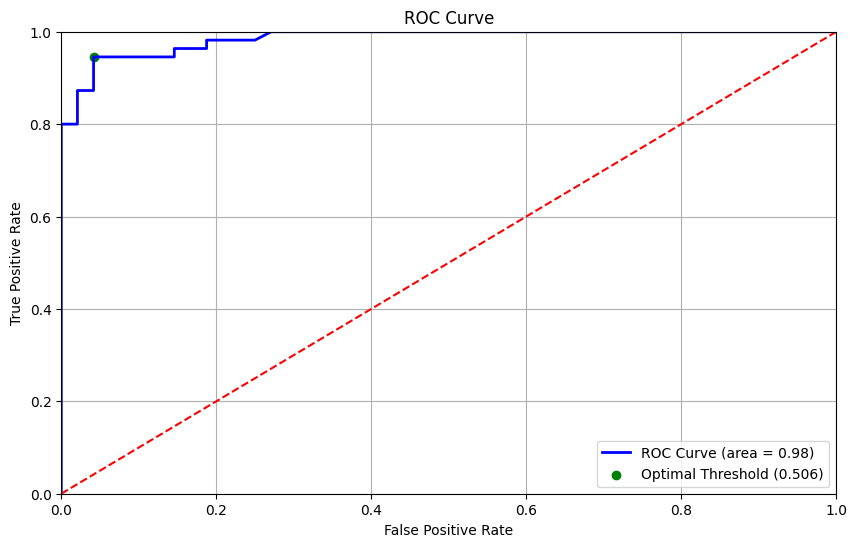

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='green', label='Optimal Threshold (0.506)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Applying Best Thresolds on testing datasets

In [ ]:
lgb_classifier = LightGBMClassifier(
            objective="binary",
            labelCol='HeartDisease',
            featuresCol='final_features', 
        )

best_hyperparams_lgb ={'boosting_type': 'gbdt', 
                       'lambda_l1': 0.27620575559776694, 
                       'lambda_l2': 0.9772563419230704, 
                       'learning_rate': 0.017050808225259315, 
                       'max_depth': 12.0, 
                       'min_data_in_leaf': 25.0, 
                       'min_gain_to_split': 0.9837550490192833, 
                       'n_estimators': 890.0, 
                       'num_leaves': 44.0}

lgb_classifier = lgb_classifier.setBoostingType(best_hyperparams_lgb['boosting_type']) \
                    .setLearningRate(best_hyperparams_lgb['learning_rate']) \
                    .setNumLeaves(int(best_hyperparams_lgb['num_leaves'])) \
                    .setMaxDepth(int(best_hyperparams_lgb['max_depth'])) \
                    .setMinDataInLeaf(int(best_hyperparams_lgb['min_data_in_leaf'])) \
                    .setMinGainToSplit(best_hyperparams_lgb['min_gain_to_split']) \
                    .setNumIterations(int(best_hyperparams_lgb['n_estimators'])) \
                    .setLambdaL1(best_hyperparams_lgb['lambda_l1']) \
                    .setLambdaL2(best_hyperparams_lgb['lambda_l2']) \

model_lgb_thres = lgb_classifier.fit(train_df_transformed)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")

test_predictions = model.transform(test_df_transformed)



Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T


to_array_udf = F.udf(lambda vector: vector.toArray().tolist() if vector is not None else None, T.ArrayType(T.FloatType()))
test_predictions = test_predictions.withColumn("probability_dense", to_array_udf("probability"))

test_predictions = test_predictions.withColumn(
    "adjusted_prediction",
    F.when(F.col("probability_dense")[1] >= 0.51, 1).otherwise(0)
)

f1_evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="adjusted_prediction", metricName="f1")

test_predictions = test_predictions.withColumn("adjusted_prediction", F.col("adjusted_prediction").cast(DoubleType()))
f1_score = f1_evaluator.evaluate(test_predictions)

print(f"Best F1 Score: {f1_score}")

Best F1 Score: 0.9012698412698412
